## Parsing and Plotting Functions

In [2]:
import matplotlib.pyplot as plt
import pickle
import utils as colab_utils
import pandas as pd
import numpy as np
import os

# LOG_PATH = '../../tmp/cartpole/83bd9453492a7242c2034a1617cc856fb8e6ebec/logs'
# Use our provided colab utils to load this log file. The second returned 
# raw_data, _ = colab_utils.load_statistics(LOG_PATH, iteration_number=2, verbose=False)

class EpisodicExperimentData():
   def __init__(self, name, episode_returns, updates, ranks, prop_left, avg_steps_per_sec):
      self.name = name
      self.episode_returns = episode_returns
      self.updates = updates
      self.ranks = ranks
      self.prop_left = prop_left
      self.avg_steps_per_sec = avg_steps_per_sec
   
   def plot_returns(self, window_size, should_save):
      returns_df = pd.DataFrame(self.episode_returns, columns = ['return'])
      sma_returns = returns_df.rolling(window=window_size).mean()

      fig, ax = plt.subplots(figsize=(15,5))
      ax.plot(sma_returns)
      ax.set(xlabel='episodes', ylabel='return')
      plt.title(f'Episode Returns: {self.name}')
      if should_save:
         plt.savefig(f'returns_{self.name}.png')
      plt.show()
   
   def plot_prop_left(self, window_size, should_save):
      prop_left_df =  pd.DataFrame(self.prop_left)
      sma_prop_left =   prop_left_df.rolling(window=window_size).mean()

      fig, ax = plt.subplots(figsize=(15,5))
      ax.plot(sma_prop_left)
      ax.set(xlabel='episodes', ylabel='proportion of actions that were left')
      plt.title(f"Proportion Left Actins: {self.name}")
      if should_save:
         plt.savefig(f'prop_left_{self.name}.png')
      plt.show()
   
   def plot_rank(self, window_size, should_save):
      sma_ranks = get_sma_all_keys(self.ranks, window_size)

      # Dump to file
      # sma_ranks["layers_1"].to_csv('ranks.txt', header=None, index=None, sep=' ', mode='a')   

      fig, ax = plt.subplots(3, figsize=(15,15))
      ax[0].plot(sma_ranks["layers_0"], 'b')
      ax[1].plot(sma_ranks["layers_1"], 'g')
      ax[2].plot(sma_ranks["layers_2"], 'm')
      ax[0].set_title(f"Layer 0 Stable Rank: {self.name}")
      ax[1].set_title(f"Layer 1 Stable Rank: {self.name}")
      ax[2].set_title(f"Layer 2 Stable Rank: {self.name}")
      for a in ax.flat:  
         a.set(xlabel='episodes', ylabel='stable rank')
      if should_save:
         plt.savefig(f'ranks_{self.name}.png')
      plt.show()
   
   def plot_updates(self, window_size, should_save):
      sma_updates = get_sma_all_keys(self.updates, window_size)

      fig, ax = plt.subplots(3, figsize=(15,15))
      ax[0].plot(sma_updates["layers_0"], 'b')
      ax[1].plot(sma_updates["layers_1"], 'g')
      ax[2].plot(sma_updates["layers_2"], 'm')
      ax[0].set_title(f"Layer 0 Updates: {self.name}")
      ax[1].set_title(f"Layer 1 Updates: {self.name}")
      ax[2].set_title(f"Layer 2 Updates: {self.name}")
      for a in ax.flat:
         a.set(xlabel='# of updates', ylabel='l1 norm of updates')
      if should_save:
         plt.savefig(f'updates_{self.name}.png')
      plt.show()
   
   def plot_avg_steps_per_sec(self, should_save):
      avg_steps_per_sec_df = pd.DataFrame(self.avg_steps_per_sec)

      fig, ax = plt.subplots(figsize=(15,5))
      ax.plot(avg_steps_per_sec_df)
      ax.set(xlabel='episodes', ylabel='avg steps per sec')
      plt.title(f'Average Steps per Second: {self.name}')
      if should_save:
         plt.savefig(f'steps_per_sec_{self.name}.png')
      plt.show()

class ContinualExperimentData():
   def __init__(self, name, rewards, avg_rewards, avg_steps_per_sec):
      self.name = name
      self.rewards = rewards
      self.avg_rewards = avg_rewards
      self.avg_steps_per_sec = avg_steps_per_sec
      
      self.cum_rewards = np.cumsum(rewards)
   
   def plot_rewards(self, window_size, should_save):
      rewards_df = pd.DataFrame(self.rewards)
      sma_rewards = rewards_df.rolling(window=window_size).mean()

      fig, ax = plt.subplots(figsize=(15,5))
      ax.plot(sma_rewards)
      ax.set(xlabel='steps', ylabel='reward')
      plt.title(f'Rewards: {self.name}')
      if should_save:
         plt.savefig(f'rewards_{self.name}.png')
      plt.show()
   
   def plot_avg_rewards(self, smoothing_factor, should_save):
      rewards_df = pd.DataFrame(self.rewards)
      ema_rewards = rewards_df.ewm(alpha=smoothing_factor).mean()

      fig, ax = plt.subplots(figsize=(15,5))
      ax.plot(ema_rewards)
      ax.set(xlabel='steps', ylabel='avg reward')
      plt.title(f'Average Reward: {self.name}')
      if should_save:
         plt.savefig(f'avg_rewards_{self.name}.png')
      plt.show()
   
   def plot_cum_reward(self, should_save):
      rewards_df = pd.DataFrame(self.cum_rewards)

      fig, ax = plt.subplots(figsize=(15,5))
      ax.plot(rewards_df)
      ax.set(xlabel='steps', ylabel='cumulative reward')
      plt.title(f'Cumulative Reward: {self.name}')
      if should_save:
         plt.savefig(f'cum_reward_{self.name}.png')
      plt.show()

def get_sma_all_keys(d, window_size):
   """Converts values in dictionary to their simple moving average"""
   sma_dict = {}
   for key, value in d.items():
      sma_dict[key] = pd.DataFrame(value).rolling(window =window_size).mean()
   return sma_dict

def recursive_items(dictionary):
    for key, value in dictionary.items():
        if type(value) is dict:
            print("key: ", key)
            yield from recursive_items(value)
        else:
            yield (key, value)

def append_updates_from_log(data, updates):
   layerwise_updates = data["agent"]["l1-update"]
   layer0_weight_updates = [x["params"]["layers_0"]["kernel"] for x in layerwise_updates]
   layer1_weight_updates = [x["params"]["layers_1"]["kernel"] for x in layerwise_updates]
   layer2_weight_updates = [x["params"]["final_layer"]["kernel"] for x in layerwise_updates]

   updates["layers_0"] = updates["layers_0"] + layer0_weight_updates
   updates["layers_1"] = updates["layers_1"] + layer1_weight_updates
   updates["layers_2"] = updates["layers_2"] + layer2_weight_updates
   return updates, len(layerwise_updates)

def append_ranks_from_log(data, ranks):
   layerwise_ranks = data["agent"]["stable-rank"]
   layer0_weight_ranks = [x["params"]["layers_0"]["kernel"] for x in layerwise_ranks]
   layer1_weight_ranks = [x["params"]["layers_1"]["kernel"] for x in layerwise_ranks]
   layer2_weight_ranks = [x["params"]["final_layer"]["kernel"] for x in layerwise_ranks]

   ranks["layers_0"] = ranks["layers_0"] + layer0_weight_ranks
   ranks["layers_1"] = ranks["layers_1"] + layer1_weight_ranks
   ranks["layers_2"] = ranks["layers_2"] + layer2_weight_ranks
   return ranks, len(layerwise_ranks)

def append_prop_left_from_log(data, prop_lefts):
   """Gets the proportion of actions that were Left per episode."""
   def get_prop_left(a):
      num_left = np.count_nonzero(np.array(a) == 0)
      return num_left/(len(a))
   prop_lefts = prop_lefts + [get_prop_left(a) for a in data["episode"]["actions"]]
   return prop_lefts

def parse_episodic_logs(experiment_name, log_path, num_logs=None):
   episode_returns = []
   updates = {"layers_0": [], "layers_1": [], "layers_2": []}
   ranks = {"layers_0": [], "layers_1": [], "layers_2": []}
   prop_left = []
   avg_steps_per_sec = []

   # Parse all logs if num_logs not specified
   if num_logs == None:
      num_logs = len(os.listdir(log_path))

   for i in range(1, num_logs):
      with open(f'{log_path}/log_{i}.pkl', "rb") as f:
         data = pickle.load(f)
      # print("stable rank: ", data["agent"]["stable-rank"])
      episode_returns = episode_returns + data["runner"]["episode_return"]
      updates, num_updates = append_updates_from_log(data, updates)
      ranks, num_ranks = append_ranks_from_log(data, ranks)
      prop_left = append_prop_left_from_log(data, prop_left)
      avg_steps_per_sec = avg_steps_per_sec + data["runner"]["train_average_steps_per_second"]

   return EpisodicExperimentData(experiment_name, episode_returns, updates, ranks, prop_left, avg_steps_per_sec)

def parse_continual_logs(experiment_name, log_path, num_logs=None):
   rewards = []
   avg_rewards = []
   avg_steps_per_sec = []

   # Parse all logs if num_logs not specified
   if num_logs == None:
      num_logs = len(os.listdir(log_path))

   for i in range(0, num_logs):
      log_file = f'{log_path}/log_{i}.pkl'
      print("Loading ", log_file)

      with open(log_file, "rb") as f:
         data = pickle.load(f)
      rewards = np.concatenate((rewards, data["runner"]["rewards"][0]))
      avg_steps_per_sec = avg_steps_per_sec + data["runner"]["train_average_steps_per_second"]
      # avg_rewards = np.concatenate((rewards, data["agent"]["avg-reward"]))

   return ContinualExperimentData(experiment_name, rewards, avg_rewards, avg_steps_per_sec)

## Parse the Logs (Single Experiment)

In [21]:
# LOG_PATH = '../../tmp/ac-pendulum/126b8fd9a3335e2e5faf3e7e7d791be765cabcf6/logs'
LOG_PATH = '../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs'

exp_data = parse_continual_logs("Pendulum DQN Continual", LOG_PATH, 19)

Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_0.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_1.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_2.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_3.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_4.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_5.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_6.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_7.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_8.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_9.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_10.pkl
Loading  ../../tmp/dqn-pendulum

## Plot the Data (Single experiment)

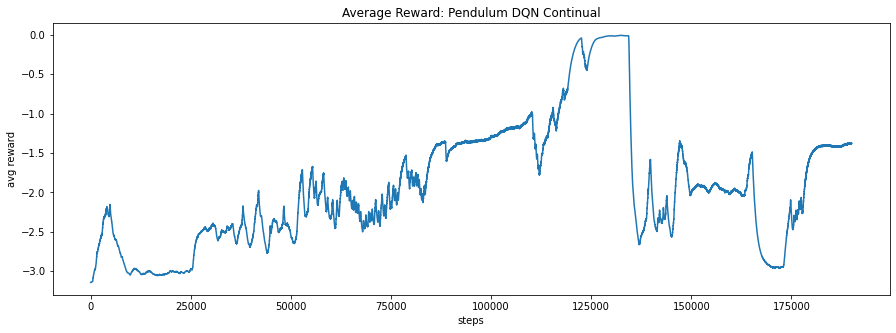

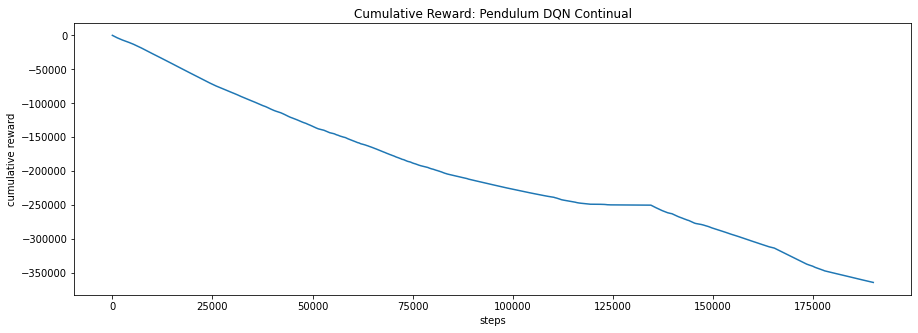

In [22]:
# Episodic Plots
# exp_data.plot_returns(window_size=10, should_save=False)
# exp_data.plot_prop_left(window_size=100, should_save=False)
# exp_data.plot_rank(window_size=1, should_save=False)
# exp_data.plot_updates(window_size=100, should_save=False)
# exp_data.plot_avg_steps_per_sec(should_save=False)

# Continual Plots
exp_data.plot_avg_rewards(smoothing_factor=0.001, should_save=False)
exp_data.plot_cum_reward(should_save=False)

## Load data from multiple runs of same experiment

In [17]:
LOG_DIRECTORY = '../../tmp/dqn-pendulum'

hashes = [
    '5040f53dfb953abd5e3ed231c33c5674bdd067f0', 
    '48bec3b889c27fcf547329a2b57955fadd0e132b',
    '6204dd62e4f40b20386839d7d070340b8828df49',
    '0a449bf01a56ca0f6f5375ebad4e4b6d788dc373',
    '47d1e4042b8c9be8f163de48a2c0de21f6a5e55f',
]

all_run_rewards = []
for hash in hashes:
    log_path = f'{LOG_DIRECTORY}/{hash}/logs'
    exp_data = parse_continual_logs("Pendulum DQN Continual", log_path, 19)
    all_run_rewards.append(exp_data.rewards)


Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_0.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_1.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_2.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_3.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_4.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_5.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_6.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_7.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_8.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_9.pkl
Loading  ../../tmp/dqn-pendulum/5040f53dfb953abd5e3ed231c33c5674bdd067f0/logs/log_10.pkl
Loading  ../../tmp/dqn-pendulum

## Plot data from multiple runs of same experiment

          0
0  0.001369
1  0.002731
2  0.004394
3  0.006390
4  0.008739
5  0.011448
6  0.014512
7  0.017919
8  0.021651
9  0.025685
(190000,)
(190000,)


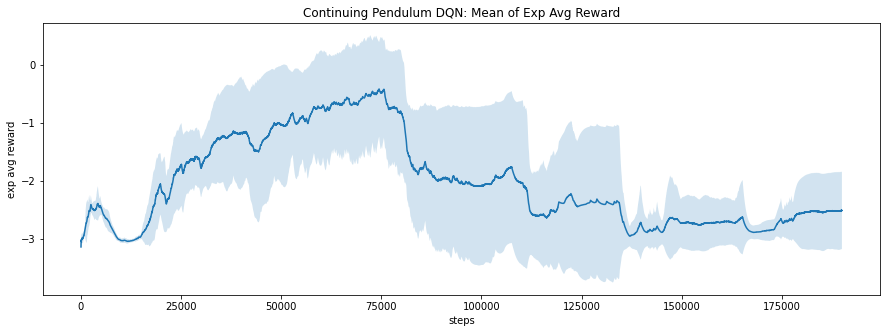

In [29]:
# Smooth results for each run using an exponential moving average
# and take the mean of this EMA over all of the runs
all_run_ema_rewards = []
for run_rewards in all_run_rewards:
    run_rewards_df = pd.DataFrame(run_rewards)
    ema_rewards = run_rewards_df.ewm(alpha=0.001).mean()
    all_run_ema_rewards.append(ema_rewards)

# Average over all of the runs
ema_rewards_mean = pd.concat(all_run_ema_rewards).groupby(level=0).mean()
data_std_err = pd.concat(all_run_ema_rewards).groupby(level=0).std()

x = range(1,len(ema_rewards_mean) + 1)
fig, ax = plt.subplots(figsize=(15,5))
ax.fill_between(x, ema_rewards_mean[0] - data_std_err[0], ema_rewards_mean[0] + data_std_err[0], alpha = 0.2)
ax.plot(ema_rewards_mean)
ax.set(xlabel='steps', ylabel='exp avg reward')
plt.title(f'Continuing Pendulum DQN: Mean of Exp Avg Reward')
# if should_save:
#     plt.savefig(f'avg_rewards_{self.name}.png')
plt.show()

## Plotting Data from many experiments

In [20]:
LOG_DIRECTORY = '../../tmp-cc/cartpole/'

class PlotConfig():
    def __init__(self, hash, name, logs_cutoff):
        self.name = name
        self.logs_cutoff = logs_cutoff
        self.logs_path = f"{LOG_DIRECTORY}/{hash}/logs"
    
    def parse_episodic_logs(self):
        return parse_episodic_logs(self.name, self.logs_path, self.logs_cutoff)

def get_experiment_name(exp_dir):
    for file in os.listdir(f"{LOG_DIRECTORY}/{exp_dir}"):
        if file.endswith(".gin"):
            return os.path.splitext(file)[0]
    return exp_dir

def plot_exploratory():
    """Parses and plots logs for all experiments in LOG_DIRECTORY"""
    for exp_dir in os.listdir(LOG_DIRECTORY):
        if exp_dir == '.DS_Store':
            continue
        
        exp_name = get_experiment_name(exp_dir)
        print(f"hash: {exp_dir}, experiment name: {exp_name}")

        # Parse logs
        logs_path = f"{LOG_DIRECTORY}/{exp_dir}/logs"
        exp_data = parse_episodic_logs(exp_name, logs_path)

        # Plot
        exp_data.plot_returns(window_size=100, should_save=False)

plot_cfgs = [
    PlotConfig("545fea39c5090d51c617d711e5f80f1af7173a4f", "Seed=54321", 350),
    PlotConfig("83bd9453492a7242c2034a1617cc856fb8e6ebec", "Default DQN Params", 200),
    PlotConfig("727d5e2fe65a229810709b6ffa84c55a6e131929", "Seed=678910", None),
    PlotConfig("24600938b186bdfa2aa763d8c13b4e146767f178", "Seed=12345", 300),
    PlotConfig("b611770428fa678aa46edd222c3b3ec8baeb9214", "Beta1=0, Beta2=0.999", 200),
    PlotConfig("bae07a929b555ca2f0395f5acf45fba0be57bfba", "Beta1=0, Beta2=0.99", None),
]

# Load data
exps_data = []
for plot_cfg in plot_cfgs:
    print(f"Loading: {plot_cfg.name}")
    exps_data.append(plot_cfg.parse_episodic_logs())

Loading: Seed=54321
Loading: Default DQN Params
Loading: Seed=678910
Loading: Seed=12345
Loading: Beta1=0, Beta2=0.999
Loading: Beta1=0, Beta2=0.99


Plotting: Beta1=0, Beta2=0.99


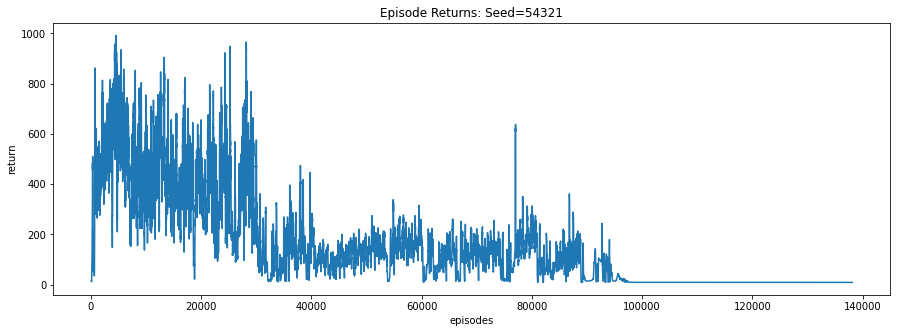

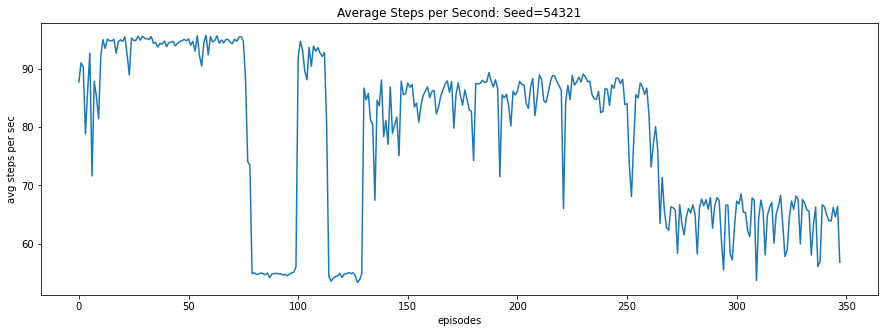

Plotting: Beta1=0, Beta2=0.99


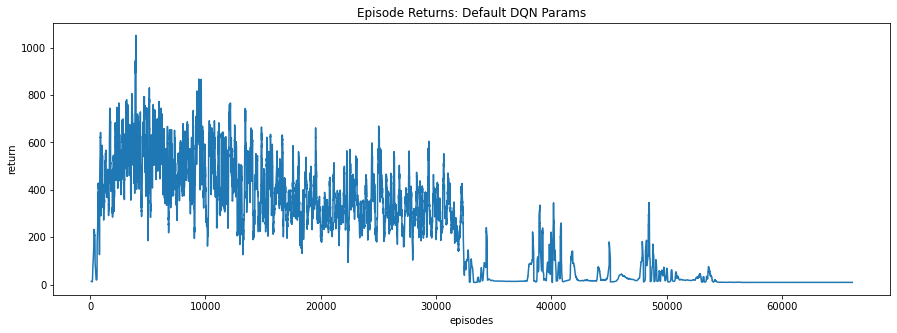

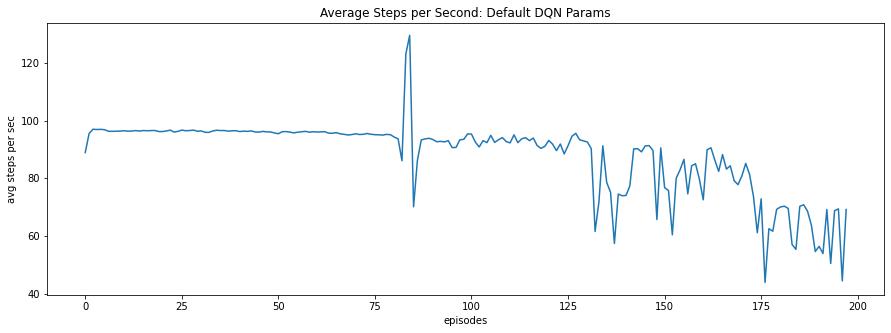

Plotting: Beta1=0, Beta2=0.99


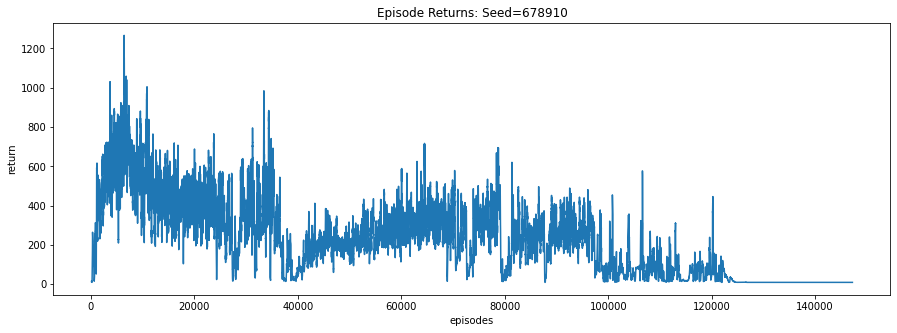

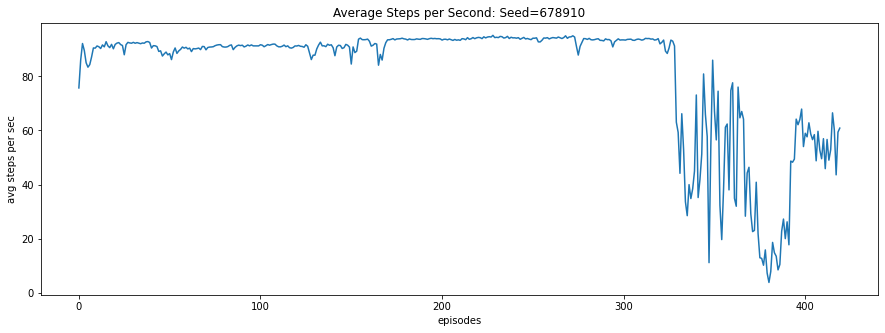

Plotting: Beta1=0, Beta2=0.99


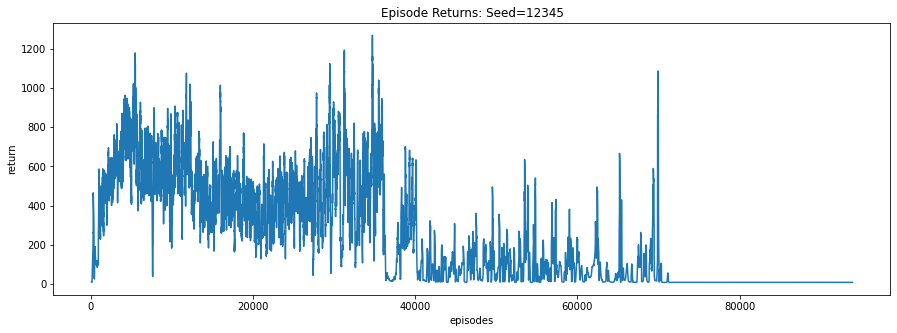

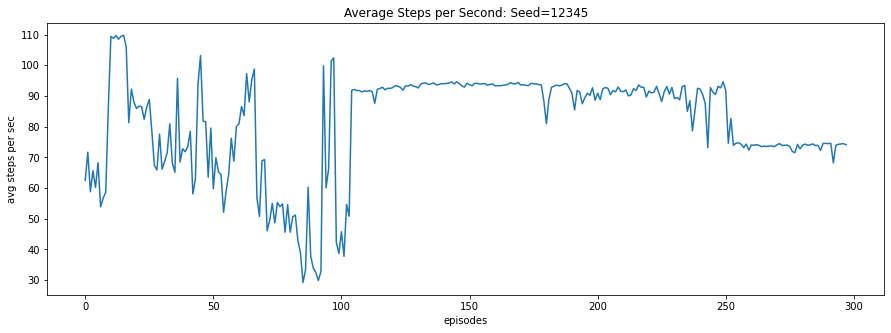

Plotting: Beta1=0, Beta2=0.99


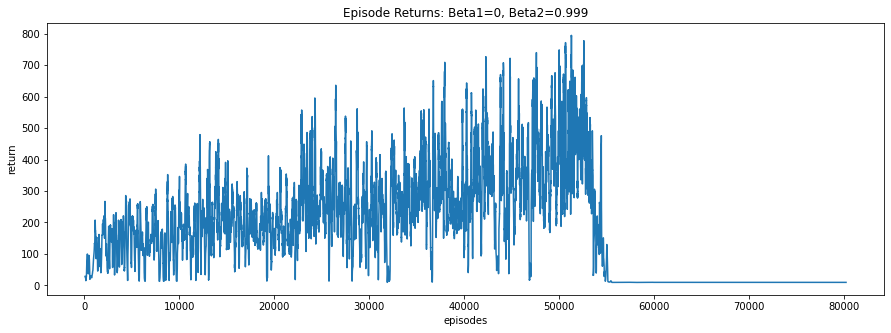

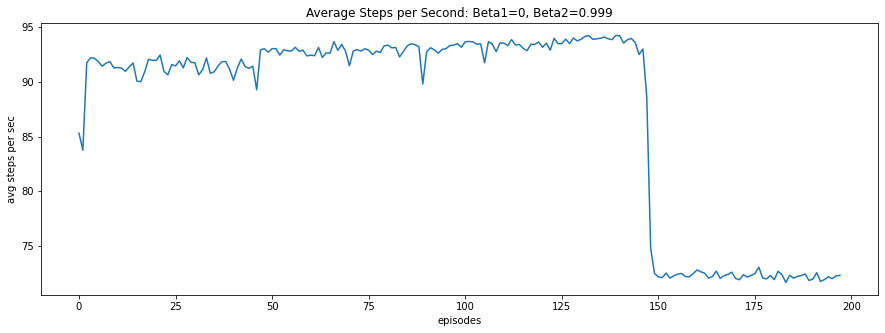

Plotting: Beta1=0, Beta2=0.99


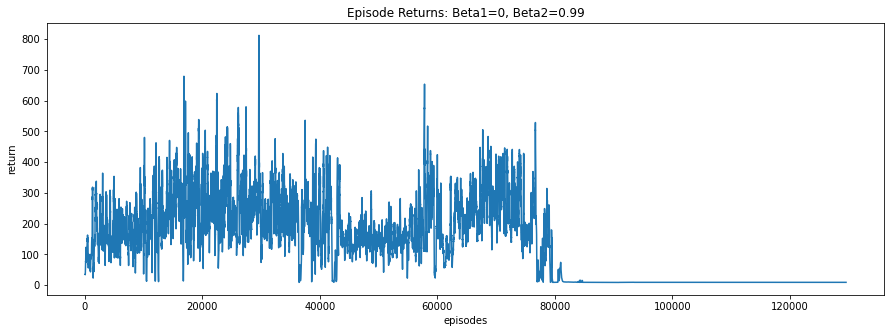

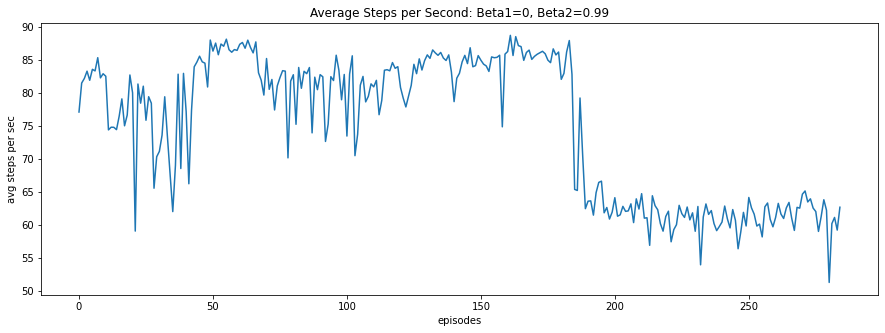

In [21]:
# plot_exploratory()

for exp_data in exps_data:
    print(f"Plotting: {plot_cfg.name}")
    exp_data.plot_returns(window_size=100, should_save=False)
    exp_data.plot_avg_steps_per_sec(should_save=False)